# DIA Pipeline Analysis 04
#### flux residual
This notebook is compatible with `desc-stack` kernel.

In [1]:
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fakeInjectionPipeline_v23 as fi
import analysis_utils as au
import matplotlib.patches as mpatches
mpl.rcParams['font.size']=14

def get_residual(fake_src_df, fake_mag):
    res_dict = {}
    fake_mag_str = str(fake_mag).replace('.', '')
    fake_src = au.slice_df(fake_src_df, equal={'fake_mag': fake_mag_str})
    detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
    src_f = detected_fake['base_PsfFlux_instFlux']
    injected_f = detected_fake['injected_instFlux']
    src_inj = (src_f - injected_f) / injected_f
    return src_inj
def get_forced_residual(fake_src_df, fake_mag):
    res_dict = {}
    fake_mag_str = str(fake_mag).replace('.', '')
    fake_src = au.slice_df(fake_src_df, equal={'fake_mag': fake_mag_str})
    detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
    src_f = detected_fake['base_PsfFlux_instFlux_forced']
    injected_f = detected_fake['injected_instFlux']
    src_inj = (src_f - injected_f) / injected_f
    return src_inj

def remove_outlier(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    dist_from_mean = abs(arr - mean)
    max_deviations = 5
    not_outlier = dist_from_mean < max_deviations * std
    no_outliers = arr[not_outlier]
    return no_outliers
def add_label(violin, label, labels):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

<module 'analysis_utils' from '/global/cscratch1/sd/shl159/projects/fake_injection_v23/dia_improvement/devel/analysis_utils.py'>

b'20'


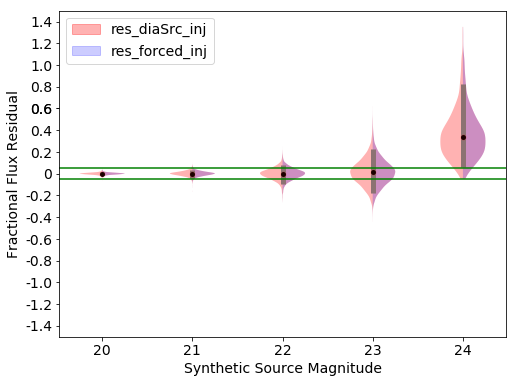

In [3]:
# how to plot half-violin plot    https://stackoverflow.com/questions/29776114/half-violin-plot-in-matplotlib

patch_list = ['00', '11', '22', '33', '44', '55', '66']
host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25']
fake_mag_list = [20, 21, 22, 23, 24]
injection_db_path = './data/table/gal_4639/injection_coord.sqlite'

calexp_info_dict, injection_coord_dict = fi.get_calexp_injection_dict(
    patch_list, host_mag_list, dbpath=injection_db_path
)
conn = sqlite3.connect('./data/patch_0to6/diff/al_default_v23/detection/detection.sqlite')
query = (f"SELECT * FROM fake_src")
fake_src = pd.read_sql_query(query, conn)

forced_db = ('./data/patch_0to6/diff/al_default_v23/forced/forced.sqlite')
conn = sqlite3.connect(forced_db)
forced_flux = pd.read_sql_query('SELECT * FROM forced', conn)

fake_src_det = fake_src.loc[fake_src.matched_status.astype(bool)].copy().reset_index(drop=True)
forced_flux_det = forced_flux.loc[forced_flux.matched_status.astype(bool)].copy().reset_index(drop=True)
print(forced_flux_det['fake_mag'][0])
forced_flux_det['host_mag'] = forced_flux_det['host_mag'].str.decode("utf-8")
forced_flux_det['fake_mag'] = forced_flux_det['fake_mag'].str.decode("utf-8")

patch_list = ['00', '11', '22', '33', '44', '55', '66']
host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25']
fake_mag_list = [20, 21, 22, 23, 24]


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

res_list = []
forced_res_list = []
for fake_idx, fake_mag in enumerate(fake_mag_list):
    res = get_residual(fake_src_det, fake_mag=str(fake_mag))
    forced_res = get_forced_residual(forced_flux_det, fake_mag=str(fake_mag))
    
    res = remove_outlier(res.array)
    forced_res = remove_outlier(forced_res.array)
    res_list.append(list(res.to_numpy()))
    forced_res_list.append(list(forced_res.to_numpy()))
parts_diaSrc = ax.violinplot(res_list, showmedians=False, showextrema=False)
parts_forced = ax.violinplot(forced_res_list, showmedians=False, showextrema=False)

labels = []

for pc in parts_diaSrc['bodies']:
    pc.set_facecolor('red')
    pc.set_edgecolor(None)

for pc in parts_forced['bodies']:
    # get the center
    m = np.mean(pc.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
    pc.set_facecolor('blue')
    pc.set_edgecolor(None)
    pc.set_alpha(0.2)
res_quartile1, res_medians, res_quartile3 = [], [], []
forced_res_quartile1, forced_res_medians, forced_res_quartile3 = [], [], []
for res in res_list:
    quartile1, medians, quartile3 = np.percentile(res, [5, 50, 95])
    res_quartile1.append(quartile1) 
    res_medians.append(medians) 
    res_quartile3.append(quartile3)

for res in forced_res_list:
    quartile1, medians, quartile3 = np.percentile(res, [5, 50, 95])
    forced_res_quartile1.append(quartile1) 
    forced_res_medians.append(medians) 
    forced_res_quartile3.append(quartile3)

add_label(parts_diaSrc, 'res_diaSrc_inj', labels)
add_label(parts_forced, 'res_forced_inj', labels)
# parts_forced['cmaxes'].set_color(['red', 'red', 'red', 'red'])
inds = np.arange(1, len(res_list) + 1)
ax.set_xticks([1,2,3,4,5])
ax.scatter(inds, res_medians, marker='o', color='black', s=15, zorder=3)
ax.scatter(inds, forced_res_medians, marker='o', color='r', alpha=0.1, s=30, zorder=3)

ax.vlines(inds, res_quartile1, res_quartile3, color='gray', linestyle='-', lw=5)
ax.vlines(inds, forced_res_quartile1, forced_res_quartile3, color='r', alpha=0.1,
          linestyle='-', lw=5)
ax.axhline(y=0.05, color='green', label="5%")
ax.axhline(y=-0.05, color='green', label="-5%")
ax.set_xticklabels(['20', '21', '22', '23', '24'])
yticks = [-1.4,-1.2,-1.0,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.6,0.8,1.0,1.2,1.4]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
# ax.tick_params(axis='y', labelsize=10)
ax.set_ylabel('Fractional Flux Residual')
ax.set_xlabel('Synthetic Source Magnitude')
ax.set_ylim((-1.5, 1.5))
    
ldg = plt.legend(*zip(*labels[0:2]), loc=2)
# plt.savefig('./paper_plots/p_res.pdf')
